[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [2]:
import os, getpass, sys
from langchain_anthropic import ChatAnthropic

#Import API Keys(storing them all in a seperate file so i run into less issues with git)
_root = "/home/zjc1002/Mounts/code/"
_langsmith_trace = 'true'
_langsmith_project = 'zjc_custom_v1'
_anthropic_model = 'claude-3-haiku-20240307'
_temparate = 0
_max_tokens = 4000
_streaming = True
_system_message = None

# This is a basic config to enable tracing of conversations and  utilization of memory
_config = {'configurable': {'thread_id':"1"}}

# Custom functions
sys.path.append(_root)
from  admin.api_keys import _api_keys
from admin.sys_ops import _set_env
from langgraph_projects.tools import get_weather, get_date, multiply, add, divide

# This anthropic and internet tool requires  API key to be set as a environment variable(s)
for api_key in ["TAVILY_API_KEY","ANTHROPIC_API_KEY",'OPENAI_API_KEY','LANGSMITH_API_KEY']:
    _set_env(api_key
            ,value =  _api_keys[api_key])

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [4]:
llm = ChatAnthropic(
    model=_anthropic_model,
    temperature=_temparate,
    max_tokens=_max_tokens,
    streaming=_streaming,
    verbose=True,
)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [5]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [8]:

def summarize_conversation(state: State):
    """_summary_

    Args:
        state (State): _description_

    Returns:
        _type_: _description_
    """
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}



We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [9]:

from langgraph.graph import END
from typing import Any, Dict, List, Literal, Optional, Tuple, Union
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", "__end__"]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) >6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return "__end__"



## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

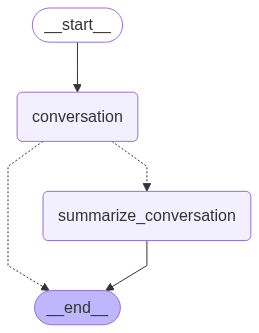

In [10]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation"\
                               , should_continue
                               , {"summarize_conversation": "summarize_conversation", "__end__": END}
                               )
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [10]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

It's nice to meet you, Lance! I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you might have. Please let me know how I can assist you.
================================== Ai Message ==================================

You told me your name is Lance, so that is the name I have for you.
================================== Ai Message ==================================

That's great that you're a fan of the San Francisco 49ers! The 49ers are a storied NFL franchise with a rich history of success, including 5 Super Bowl championships. They have had many legendary players and coaches over the years. As an AI, I don't have personal sports allegiances, but I can certainly appreciate the passion and excitement that comes with being a devoted fan of a team. Let me know if you'd like to discuss the 49ers or football in general - I'm happy to chat about the sport and share any rel

Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [11]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [12]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

You're right, Nick Bosa is one of the highest paid defensive players in the NFL currently. Here are some key details:

- In 2022, Bosa signed a 5-year, $135 million contract extension with the San Francisco 49ers, making him one of the highest paid non-quarterbacks in the league.

- The deal includes $80 million in guaranteed money, which is the most ever for a defensive player.

- Bosa's average annual salary of $27 million per year makes him the highest paid defensive player in the NFL, surpassing the previous record held by Aaron Donald of the Los Angeles Rams.

- Bosa is coming off an outstanding 2021 season where he recorded 15.5 sacks and was named NFL Defensive Player of the Year. He's emerged as one of the premier pass rushers in the league.

- The 49ers made Bosa a priority to lock up long-term, as he's a cornerstone of their defense and one of the best young defensive players in the NFL.

So you

In [13]:
graph.get_state(config).values.get("summary","")

"Here is a summary of our conversation so far:\n\nWe started with me introducing myself as an AI assistant created by Anthropic. You then told me your name is Lance and that you are a fan of the San Francisco 49ers football team.\n\nYou mentioned that you like 49ers player Nick Bosa, and asked if he is the highest paid defensive player in the NFL. I confirmed that this is correct - Bosa recently signed a 5-year, $135 million contract extension with the 49ers, making him the highest paid non-quarterback in the league based on average annual salary.\n\nI provided some additional details, noting that Bosa's deal includes $80 million in guaranteed money, which is the most ever for a defensive player. I also mentioned that Bosa is coming off an outstanding 2021 season where he was named NFL Defensive Player of the Year, solidifying his status as one of the premier pass rushers in the NFL.\n\nOverall, our discussion has focused on your fandom of the 49ers, particularly your appreciation for 

## LangSmith

Let's review the trace!